<a href="https://colab.research.google.com/github/Davidlm613/capstone/blob/main/NLP_PersonalityType.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Use Natural Language Processing to Predict Myers Briggs Personality Types**



---

By David Maccornack & Lauren LoBue July 2021

# Problem Definition 

Can we train a computer model to identify somebody's personality type based on social media posts?

This analysis aims to use several artificial intelligence and machine learning models to teach a model to identify and distinguish the 16 different Myers-Briggs personality types. Additional information on the personality types can be found here: [Types](https://www.myersbriggs.org/my-mbti-personality-type/mbti-basics/the-16-mbti-types.htm)

This is a supervised multiclass, classification machine learning analysis using Natural Language Processing (NLP) for preprocessing steps, followed by Naive Bayes and XGBoost for categorical predictions and model refining. 

We are using a 'free' level of Google Colab, we tried running a GPU and got marginal improvemnt on the run time of the XGBoost model.  But it may have been causing some issues with running the XGBoost cell, it could have been causing a failure to relaunch the runtime.  

# Data Collection

The Myers Briggs Type Indicator (MBTI) training data was provided by Daria Hlibova on GitHub and contains over 8,600 rows of information to identify the personality types. [GitHub](https://github.com/dashascience/-MBTI-Myers-Briggs-Personality-Type-Dataset) 

The MBTI dataset divides each entry or person into 16 distinct personality types across 4 axis:

*   Introversion (I)
*   Extroversion (E)
*   Intuition (N)
*   Sensing (S)
*   Thinking (T)
*   Feeling (F)
*   Judging (J)
*   Perceiving (P)


The data for this analysis was imported from Google Colab, Cohort 5. [CSV](https://drive.google.com/file/d/1oClia9vlMJaFyT2uokenqGn1D86czMRZ/view?usp=sharing)



## Imports 

Several traditional packages were imported for this analysis including: 
- Numpy
- Pandas
- Matplotlib
- re (Regular Expression) 

Other specialized packages that were used include: 

From SKLearn
- Naive_bayes: CategoricalNB 
- Feature_extraction: CountVectorizor, TfidfVectorizor, TfidfTransformer
- Model_Selection: Train_Test_Split 
- Decision Tree Classifier

From nltk (Natural Language ToolKit)
- Corpus: Stopwords 


In [ ]:
# ignore warnings to keep analysis 'clean'
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
import re
import string
import nltk
import sklearn.model_selection as model_selection
import sklearn.model_selection as model_selection
from sklearn import metrics
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn import metrics  
from sklearn.model_selection import GridSearchCV

## File Path

CSV data from the following drive:

In [ ]:
from google.colab import drive
drive.mount('/drive')

training_path = '/drive/My Drive/mbti_1.csv'

Mounted at /drive


## Load Data

The data was successfully imported. Below one can see the first few rows and the basic format of how the dataset is set up. 

In [ ]:
mb = pd.read_csv(training_path)  
mb.head(10)

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...
5,INTJ,'18/37 @.@|||Science is not perfect. No scien...
6,INFJ,"'No, I can't draw on my own nails (haha). Thos..."
7,INTJ,'I tend to build up a collection of things on ...
8,INFJ,"I'm not sure, that's a good question. The dist..."
9,INTP,'https://www.youtube.com/watch?v=w8-egj0y8Qs||...


In [ ]:
# make a copy of the data and perform analysis on copy
df= mb.copy()

## Brief Data Overview

General information about the data set.

Data contains:
-  8675 rows
-  Columns : 'Type' | 'Posts'
- Complete dataset or no null values

In [ ]:
# dataframe basic info
print(df.shape)
print(df.isna().sum().sum()) # check for null values
print(df.columns)
print(df.dtypes)

(8675, 2)
0
Index(['type', 'posts'], dtype='object')
type     object
posts    object
dtype: object


# Data Cleaning 

As seen above, the data includes extra characters and URL information that require extensive 'cleaning' prior to running analysis. We accomplished this by using Regular Expression (re) methods like 'split', 'lower' and 'sub'.  


## Split Rows 

Initially, the posts are organized in a way that has each persons posts/comments all grouped together by |||, so a specific example of the cleaning performed include spliting the data at |||, which essentially separates the individual posts into a list of 'strings'. 

In [ ]:
# split each post into separately record
df ['posts'] = df['posts'].apply(lambda c: c.split('|||'))

## Removing or Replacing Punctuation

Below are the methods used to remove punctuation, such as the '\' and then replace some of the punctuation with its word equivalant. For example, switching out '!' for the word 'exclamation'. 

This was decided because it is possible that some of the personality types may be more expressive and use exclamation marks or others may be more curious and ask questions, so we decided to include this information in the analysis. 

In [ ]:
## Remove ''\'
df['posts'] = df['posts'].apply(lambda r: re.sub(r'\'', '', str(r)))

In [ ]:
## Define punctuation and values to trade them with.
punct_marks = [r'\?', r'\!', r'\...', r'\#', r'\.', r'\"', r'\,']
punct_name = [" question ", " exclamation ", " lasting ", " hashtag ", " period  ", "", " comma "]
punct_dict = dict(zip(punct_marks, punct_name))

In [ ]:
## Replace punctuation based on the dictionary above.  Replaces '?' with 'question', etc.
df2 = pd.DataFrame(columns=['type', 'posts'])
for i in range(7):
  df2['posts'] = df['posts'].apply(lambda x: re.sub(punct_marks[i], punct_name[i], str(x)))


## Lowercase All Text 

Leaving all the posts in the traditional sentance structure can have implication on the output or results of the predictions. Applying the 'lowercase' method allows the model to consolidate words with identitical meaning, putting more weight behind them.  

In [ ]:
df2['posts'] = df2['posts'].apply(lambda r: r.lower())

In [ ]:
## Remove all URLs from the dataset.  Although some of the URLs could be correlated with personality types, I don't think that they would contribute much simply becasue
## there are so few of them.  
df2['posts'] = pd.Series(re.sub('http\S+', '', str(df2.posts.iloc[i])) for i in range(0, len(df)))

In [ ]:
df2['type'] = df['type'].copy()

In [ ]:
df2['posts']

0       [" comma   comma  enfp and intj moments    spo...
1       ["im finding the lack of me in these posts ver...
2       ["good one  _____    comma  "of course comma  ...
3       ["dear intp comma    i enjoyed our conversatio...
4       ["youre fired." comma  "thats another silly mi...
                              ...                        
8670    [" comma  ixfp just because i always think of ...
8671    ["so...if this thread already exists someplace...
8672    ["so many questions when i do these things.  i...
8673    ["i am very conflicted right now when it comes...
8674    ["it has been too long since i have been on pe...
Name: posts, Length: 8675, dtype: object

In [ ]:
# example of new type -- series instead of object
##### !!! example of new type -- list instead of object 
### !!!! I may have broken this..... I didn't see where list was coming from so I took the row index out.  Also it's a series now, IDK when that changed but it works so i'm going with it!
type(df2['posts'])

pandas.core.series.Series

## Balance Classes 

In [ ]:
# As the following counts show there are almost 47 times as many rows for 'INFP' (1832) then there are 'ESTJ' (39).  That would not work well on it's own.  With the classes (personality types) so imballanced 
# I would guess that it would likely classify more into the four groups with >1000, maybe some soptty assignments to the eight with between 100 and 700, and either noneor  very few assigned to the last four <90

# We did try 'down sampling' to make each personality type be represented by 39 of their rows.  This didn't work very well, it just wasn't enough data for the model to really begin identifying each class.
# Accuracy was around 20%
df2['type'].value_counts()

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

In [ ]:
# The solution to the problems with 'down sampling' is to try 'up sampling'.  Basically this just allows repeating the rows for the personality types with very few rows to reach a specified number of rows.
# So this allows using a portion of the entries with large numbers of rows, and repeating the entries for personality types with only a few, to fill a set number of rows
df_new = df2.groupby('type').sample(n=600, random_state=1, replace = True)

In [ ]:
# This is not necassarily needed, it is just to give a very brief over view of the principle of up/down sampling.
# This just shows an example of how many times each personality type would need to be repeated to fill 600 rows (number < 1 means that less then the number of rows avalible was needed to fill our 600).
round(600/df2['type'].value_counts(), 2)

INFP     0.33
INFJ     0.41
INTP     0.46
INTJ     0.55
ENTP     0.88
ENFP     0.89
ISTP     1.78
ISFP     2.21
ENTJ     2.60
ISTJ     2.93
ENFJ     3.16
ISFJ     3.61
ESTP     6.74
ESFP    12.50
ESFJ    14.29
ESTJ    15.38
Name: type, dtype: float64

In [ ]:
# Shows that the new dataframe has 600 entries for each personality type
df_new['type'].value_counts()

ISFP    600
ENFJ    600
ISFJ    600
ESTJ    600
INTP    600
ESTP    600
INTJ    600
ESFP    600
ESFJ    600
ENTP    600
ENFP    600
ISTP    600
INFP    600
INFJ    600
ISTJ    600
ENTJ    600
Name: type, dtype: int64

# Exploratory Data Analysis (EDA)

## Transition to Numerical Data


Below is the syntax for TFIDF Vectorizer and removing 'stop' words


In [ ]:
# Syntex for Vectorization -- combines above two steps into this one step 
# this may be a repeat
tfidf_vec = TfidfVectorizer(stop_words = 'english')
tfidf_data = tfidf_vec.fit_transform(df_new['posts'])


In [ ]:
# replace all 'type' names into numerical values for future analysis
rep_dict = {'INFP' : 1, 'INFJ' :2, 'INTP' :3, 'INTJ' :4, 'ENTP': 5, 'ENFP' :6, 'ISTP' :7, 'ISFP' :8, 'ENTJ' :9, 'ISTJ' :10, 'ENFJ' :11, 'ISFJ'  :12, 'ESTP' :13, 'ESFP' :14, 'ESFJ' :15, 'ESTJ' :16}
num_y = df_new['type'].replace(rep_dict)
num_y

1625    11
6444    11
3147    11
6219    11
5810    11
        ..
1330     7
4773     7
7347     7
4427     7
7945     7
Name: type, Length: 9600, dtype: int64

In [ ]:
# checking and confirming classes still equal in value counts 
num_y.value_counts()

15    600
7     600
14    600
6     600
13    600
5     600
12    600
4     600
11    600
3     600
10    600
2     600
9     600
1     600
16    600
8     600
Name: type, dtype: int64

# Data Analysis

Initial pass with Nieve Bayes 

In [ ]:
# pull in model_selection and MultinomialNB from SKlearn

x_train, x_test, y_train, y_test = model_selection.train_test_split(tfidf_data, df_new['type'])

multi_bayes = MultinomialNB()
multi_bayes.fit(x_train, y_train)
y_pred = multi_bayes.predict(x_test)
print("Number of mislabeled points out of a total %d points : %d"
      % (x_test.shape[0], (y_test != y_pred).sum()))
print(f"Percent correctly labeled: {((y_test == y_pred).sum())/24}")

Number of mislabeled points out of a total 2400 points : 701
Percent correctly labeled: 70.79166666666667


# Cross Validation

In [ ]:
# run accuracy scores and find % accuracy 
n = 10
results = cross_val_score(multi_bayes, tfidf_data, df_new['type'], scoring='accuracy', cv = n)
print(results) # run through n times 
accu_results  = results.mean() # average of accuracy 
results_mnb = results
print(f"The average accuracy for the {n} runs is: {round(accu_results*100, 4)}")

[0.784375   0.79375    0.7875     0.79166667 0.78854167 0.803125
 0.790625   0.79375    0.784375   0.7875    ]
The average accuracy for the 10 runs is: 79.0521


# Data Visualization

 Naive Bayes results 

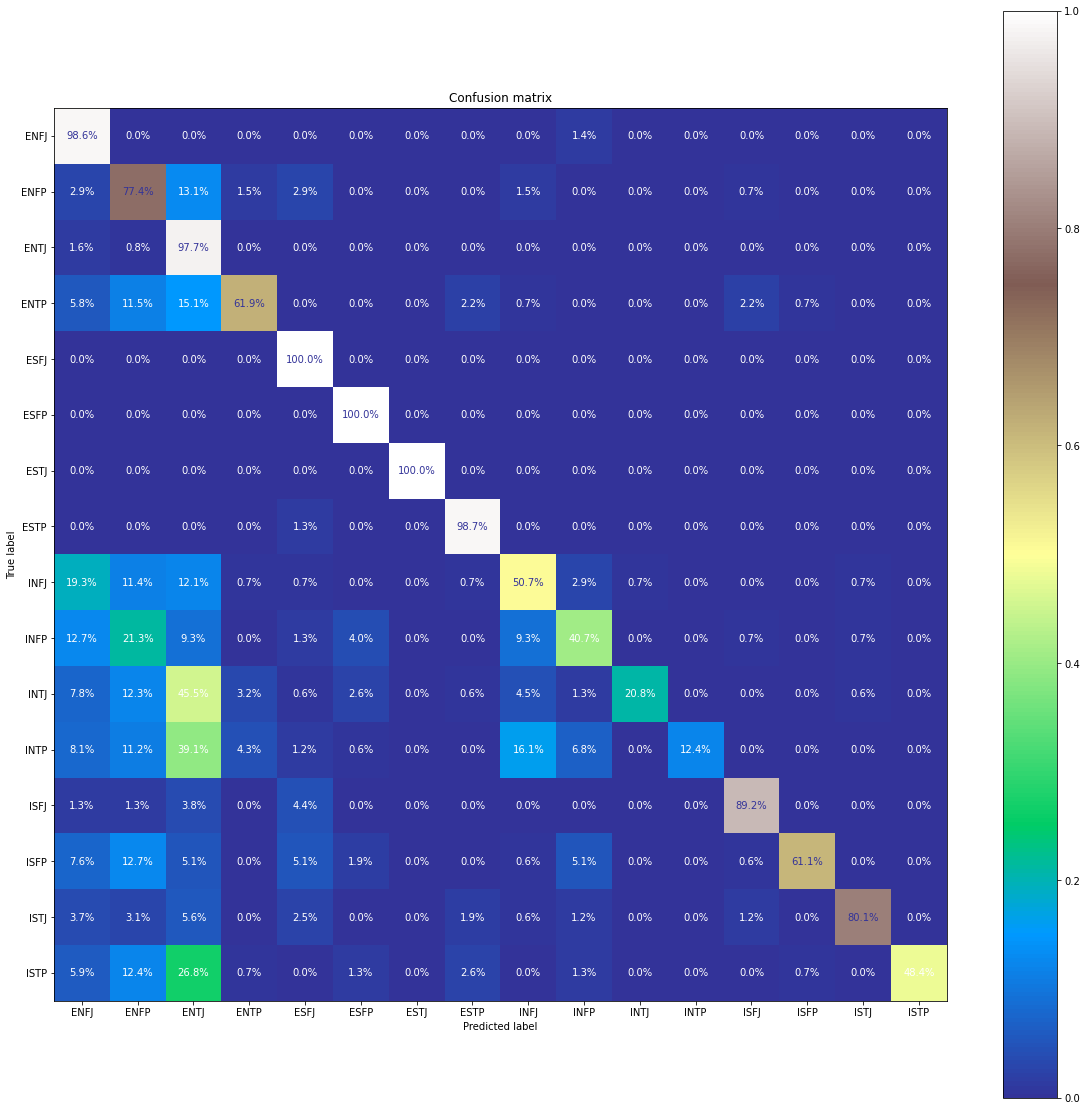

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
metrics.plot_confusion_matrix(multi_bayes, x_test, y_test, ax = ax, normalize = 'true', values_format = '.1%', cmap='terrain')
plt.title('Confusion matrix')
plt.show()
#plt.savefig('/content/drive/My Drive/Test_confusion_matrix.png')

# Tree Based Model

In [ ]:
from xgboost import XGBClassifier

In [ ]:
# can change the number of loops
loops = 10

# prefill loops with zeros as placeholders
accuracy_xgb = np.zeros(loops)


#root_mean_percnt_error_xgb
# for loop to cycle through 
for index in range(0,loops):
  x_train, x_test, y_train, y_test = model_selection.train_test_split(tfidf_data, num_y, test_size = 0.15)
  xgboost_model = XGBClassifier(objective = 'multi:softmax', num_class=17, verbosity = 0, seed = 8)

# fit the model x_train   X_train_tfidf, train_re
  xgboost_model.fit(x_train, y_train) #astype(float)
  
# predictions 
  type_predictions_xgb = xgboost_model.predict(x_test)

# loop through the index of zeros and fill them with test vs predicted values -- returning MSE
  accuracy_xgb[index] = accuracy_score(y_test,type_predictions_xgb)


accuracy_xgb_1 = accuracy_xgb.mean()

# I'm saving this.  Because I dont want to have to wait 2 hours to start working on the line plot
pd.Series(accuracy_xgb).to_csv('/content/drive/MyDrive/Student Folder - David/Capstone/xgb_accuracy.csv')

print(f"Accuracy score for XGBoost model: {accuracy_xgb_1*100}%")

FileNotFoundError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# display_labelsarray-like of shape (n_classes,), default=None

# Target names used for plotting. By default, labels will be used if it is defined, otherwise the unique labels of y_true and y_pred will be used.

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
metrics.plot_confusion_matrix(xgboost_model, x_test, y_test, ax = ax, normalize = 'true', values_format = '.1%', cmap='terrain')
plt.title('Confusion matrix')
plt.show()
#plt.savefig('/content/drive/My Drive/Test_confusion_matrix.png')

In [ ]:
parameters = {
    'max_depth': [17,19,21], 
    'learning_rate' : [0.1, 0.3, 0.5], 
    'tree_estimators': [5, 7, 10]  
}

# Use Grid Search to find best fit

search_for_best = GridSearchCV(estimator=xgb.XGBRegressor(objective = 'multi:softmax' ,seed=10), param_grid=parameters, scoring='accuracy')

# Fit to training data
x_train, x_test, y_train, y_test = train_test_split(tfidf_data, num_y,test_size = 0.15)
fit_model = search_for_best.fit(x_train, y_train)

# See grid results
print(fit_model.best_params_)

#Line plot

In [ ]:
try:
  xgb_plot = pd.Series(accuracy_xgb).apply(lambda g: g*100)
  print("New data to plot!")
except:
  xgb_plot = pd.read_csv('/content/drive/MyDrive/Student Folder - David/Capstone/xgb_accuracy.csv')
  xgb_plot.drop('Unnamed: 0', axis=1, inplace=True)
  xgb_plot = xgb_plot.apply(lambda f: f*100)
  print("No new data to plot.  Have to use saved data.")

In [ ]:
mnb_plot = pd.Series(results_mnb)


In [ ]:
mnb_plot_ave = results_mnb.mean()
xgb_plot_ave = accuracy_xgb2.mean()
print(results_mnb.mean(), accuracy_xgb2.mean())

In [ ]:
f = plt.figure()
f.set_figwidth(13)
f.set_figheight(10)

SMALL_SIZE = 12
MEDIUM_SIZE = 17
BIGGER_SIZE = 22
LEGEND_SIZE = 15

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
#plt.rc.Params.update({'font.size': 22})

plt.plot(xgb_plot, '-g', label='XGBoost')
plt.plot(mnb_plot, '-b', label='MultinomialNB')
plt.axis([0,9, 69, 95])

plt.hlines(mnb_plot_ave, 0, 9, colors='lightsteelblue', linestyles='solid', label='MultinomialNB Mean')
plt.hlines(xgb_plot_ave, 0, 9, colors='lightseagreen', linestyles='solid', label='XGBoost Mean')

plt.xlabel('Epoch')
plt.ylabel('Accuracy (percentage correctly classified)')
plt.suptitle('Accuracy of XGBoost model and \nMultinomialNB over 10 Epochs')
plt.legend(['XGBoost', 'MultinomialNB', 'XGBoost Mean', 'MultinomialNB Mean'])

#Word clouds

##From discriptions

###INTP

In [ ]:
import pandas as pd
import numpy as np
import requests as re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from bs4 import BeautifulSoup

In [ ]:
intp = re.get('https://www.16personalities.com/intp-personality')
intp_r = intp.content
intp_soup = BeautifulSoup(intp_r, 'html.parser')
intp_soup = intp_soup.find_all(text=True)
intp_soup

In [ ]:

intp2 = re.get('https://www.verywellmind.com/intp-introverted-intuitive-thinking-perceiving-2795989')
intp2_r = intp2.content
intp2_soup = BeautifulSoup(intp2_r, 'html.parser')
intp2_soup = intp2_soup.find_all(text=True)
intp2_soup

In [ ]:
intp2_soup

output2 = ''
blacklist = [
    '[document]',
    'noscript',
    'header',
    'html',
    'meta',
    'head', 
    'input',
    'script',
    # there may be more elements you don't want, such as "style", etc.
]
for t in intp2_soup:
    if t.parent.name not in blacklist:
        output2 += '{} '.format(t)

output2

In [ ]:
output2 = output2.replace('\n', '')
output2

In [ ]:
output = ''
blacklist = [
    '[document]',
    'noscript',
    'header',
    'html',
    'meta',
    'head', 
    'input',
    'script',
    # there may be more elements you don't want, such as "style", etc.
]
for t in intp_soup:
    if t.parent.name not in blacklist:
        output += '{} '.format(t)

print(output)

In [ ]:
str(output2).find('Tips for Interacting With INTPs ')

In [ ]:
str(output).find('\n Logician  Personality \n INTP-A')

In [ ]:
out2_trim = str(output2)[3986:]

In [ ]:
str(out2_trim).find('Was this page helpful?  ')

In [ ]:
intp2_clean = str(out2_trim)[:7894]

In [ ]:
out_trim = str(output)[1167:]

In [ ]:
str(out_trim).find(' \n 01 \n \n \n \n')

In [ ]:
out_cut = str(out_trim)[:5143]
intp_clean = out_cut.replace('\n', '')

In [ ]:
intp_t_clean = intp_clean + intp2_clean

In [ ]:
print(len(intp_clean), len(intp2_clean), len(intp_t_clean))

In [ ]:
#intp_t_clean = intp_t_clean.replace('INTP', ' ')

In [ ]:
word_c = WordCloud(max_font_size=40, max_words=100).generate(intp_t_clean)
plt.figure(figsize = (20,10))
plt.imshow(word_c, interpolation='bilinear')
plt.axis("off")
plt.show()    # rather type

###ENFJ

In [ ]:
enfj_r = 

In [ ]:
#enfj_t_clean = enfj_t_clean.replace('ENFJ', ' ')
#enfj_t_clean = enfj_t_clean.replace('enfj', ' ')
enfj_t_clean = enfj_t_clean.replace('sometimes', ' ')
enfj_t_clean = enfj_t_clean.replace('often', ' ')
enfj_t_clean = enfj_t_clean.replace('even', ' ')
enfj_t_clean = enfj_t_clean.replace('many', ' ')

In [ ]:
word_c = WordCloud(max_font_size=40, max_words=100, background_color="white", prefer_horizontal=0.85).generate(enfj_t_clean)
plt.figure(figsize = (20,10))
plt.imshow(word_c, interpolation='bilinear')
plt.axis("off")
plt.show()

##From posts used for classification

###INTP

In [ ]:
intp_d = df2[df2['type'] == "INTP"]

In [ ]:
intp_d = ''.join(intp_d['posts'])

In [ ]:
intp_d = intp_d.replace(" question ", "")
intp_d = intp_d.replace(" exclamation ", ' ')
intp_d = intp_d.replace(" lasting ", ' ')
intp_d = intp_d.replace(" hashtag ", ' ')
intp_d = intp_d.replace(" period ", ' ')
intp_d = intp_d.replace("comma", "")

In [ ]:
intp_d

In [ ]:
word_c = WordCloud(max_font_size=40, max_words=150, background_color="white", prefer_horizontal=0.85).generate(intp_d)
plt.figure(figsize = (20,10))
plt.imshow(word_c, interpolation='bilinear')
plt.axis("off")
plt.show()

###ENFJ

In [ ]:
enfj_d = df2[df2['type'] == "ENFJ"]

In [ ]:
enfj_d = ''.join(enfj_d['posts'])

In [ ]:
enfj_d = enfj_d.replace(" question ", "")
enfj_d = enfj_d.replace(" exclamation ", ' ')
enfj_d = enfj_d.replace(" lasting ", ' ')
enfj_d = enfj_d.replace(" hashtag ", ' ')
enfj_d = enfj_d.replace(" period ", ' ')
enfj_d = enfj_d.replace("comma", "")

In [ ]:
enfj_d

In [ ]:
word_c = WordCloud(max_font_size=40, max_words=150, background_color="white", prefer_horizontal=0.85).generate(enfj_d)
plt.figure(figsize = (20,10))
plt.imshow(word_c, interpolation='bilinear')
plt.axis("off")
plt.show()

# Conclusion


## Important Features and Model Performance 


## Future Exploration & Next Steps

